<a href="https://colab.research.google.com/github/KabirSubbiah/NLP/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Introduction

In this project you will leverage skills that you have learnt in the past few weeks, such as Topic Modeling, Latent Dirichlet Allocation to build a small model analyzing the content of news articles from different sources around the US.

The main learning objectives for this assignment are:
1. Use LDA topic modeling to find patterns in a realistic, noisy, unlabeled text corpus
2. Understand how topic modeling results are influenced by preprocessing and hyperparemters
3. Use dimensionality reduction and clustering algorithms to create effective visualizations of large text data

Note: At some points in the assignment, we'll format some parts of instructions in all-caps. We're not yelling! We just think they're very important details that you must take note of.  

# Installation and Imports

In [1]:
# Mount the drive to be able to read and write files from your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Python Import Statements
import re
from typing import *
import collections
import sys
import math
import numpy as np
import csv
import spacy
from tqdm import tqdm
from os.path import exists
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# To only run autograder tests 1 and 2, for example, comment this out:
# TESTING_NUM_FLAG = [1,2]

# Part 1: Basic Topic Model

First, let's train a basic topic model and see what happens! We'll do very basic text preprocessing (tokenization and lower casing) to start, and we'll use LSA for the topic model.

You can download the dataset [here](https://drive.google.com/file/d/1146a1rhJ95NEySuMS000KDRPcat-itPh/view?usp=sharing) - we've handled loading it below.

**Warning**: Loading the data could take as much as 10 minutes when running for the first time. After that, the parsed documents are cached in a pickle file...

In [3]:
######################
#     LOAD DATA      #
#############################################################################################################################
# This cell block will load in the dataset into                                                                             #
#   * spacy_processed_docs - A list of Spacy Documents that we can use as data to train our Topic Model                     #
#   * doc_locations - A list of States where each Document was sourced from (This will be used in Part 3: Visualization)    #
#############################################################################################################################

num_documents = 5000 # INFO: Feel free to change this to load in less documents for debugging but otherwise keep it at 5000 to train the Topic Model
FILEPATH = "/content/drive/MyDrive/datasets/" # TODO: Update this to the filepath of your copy of the assignment, e.g. /content/drive/MyDrive/Topic Modeling/

nlp = spacy.load('en_core_web_sm')

doc_locations = []
spacy_processed_docs = []

if exists(f"{FILEPATH}spacy_processed_docs_{num_documents}.pkl"):
  with open(f"{FILEPATH}spacy_processed_docs_{num_documents}.pkl", 'rb') as f:
    spacy_processed_docs, doc_locations = pickle.load(f)
    f.close()
else:
  with open(f'{FILEPATH}articles_sampled_data.csv', 'r', encoding='utf-8') as f:
    for i, row in tqdm(enumerate(csv.DictReader(f, delimiter=','))):
      if i == num_documents:
        break
      if i % 500 == 0:
        print("Processing row %d"%i)
      try:
        parsed = nlp(row["content"])
        source_name = row["location"]
      except ValueError:
        continue
      spacy_processed_docs.append(parsed)
      doc_locations.append(source_name)
    f.close()

  with open(f"{FILEPATH}spacy_processed_docs_{num_documents}.pkl", 'wb') as f:
    pickle.dump((spacy_processed_docs, doc_locations), f)
    f.close()

In [4]:
# Run this to make sure that the data is loaded in correctly, there should be 5000 documents
print("PROCESSED")
print(spacy_processed_docs[0])
print(f"\nNumber of documents: {len(spacy_processed_docs)}")

PROCESSED
By Special to the Advance

Spain Park’s Sarah Ashlee Barker is the Alabama Sports Writers Association 33rd Miss Basketball and first from Spain Park.

The Georgia signee is also the Gatorade state Player of the Year, the MaxPreps state Player of the Year, the AL.com Player of the Year and the AL.com Birmingham Region Player of the Year.

She has been selected to the Alabama Sports Writers Association All-State team each of the past three seasons and is the two-time Class 7A Player of the Year.

Barker led the Jaguars to their second Class 7A state championship in the past three seasons, averaging 23.3 points, 10.9 rebounds and 2.7 assists this season for coach Mike Chase.

She earned Class 7A tournament MVP this season and was also named all-tournament on Spain Park’s 2018 championship team and 2017 finalist squad.

Number of documents: 5000


To start, let's build the following components for topic modeling:

1.  **M**:
    A binary term-document matrix of shape (num_documents, vocab_size)

2.  **word2idx**: A dictionary which maps each word to its rank in the vocabulary (e.g. the most frequent word should have rank 0, the second most frequent word rank 1, etc).

3.  **idx2word**: The inverse of the above (i.e., mapping from index to word)

You will use **M** to train the topic model directly, and you will use the other two lookup tables in order to analyze the actual topics produced. You should use spacy to ***TOKENIZE*** and ***LOWERCASE*** the raw text, but not do any additional preprocessing.
When lowercasing, please use `token.lemma_.lower()`

In [5]:
from collections import Counter
def binary_term_doc_matrix(docs : List[spacy.tokens.Doc]) -> Tuple[np.ndarray[np.float64], Dict[int, str]]:
  """
  Preprocess and transform docs to create our binary term-document matrix and dictionaries as described above
  TODO: You will need to fill in word2idx and idx2word, and then M
  HINT: Make sure to use token.lemma_.lower() to lowercase text rather than token.text.lower()

  Parameters
  ----------
  docs : List[Doc]
    A list of spacy processed documents (i.e. each item is the output of nlp(article))

  Returns
  -------
  M : np.ndarray[float]
    The binary term-document matrix, each value in M should be either 0 or 1
  idx2word : Dict[int, str]
    The dictionary that maps each index/rank to each word in the vocabulary
  """
  cnt = Counter()
  word2idx = {}
  idx2word = {}

  for doc in docs:
    for token in doc:
      token = token.lemma_.lower()
      if token in cnt:
        cnt[token] += 1
      else:
        cnt[token] = 1
  print(f'Counter of length {len(cnt)} set up')

  idx = 0

  for token, occurences in cnt.most_common():
    idx2word[idx] = token
    word2idx[token] = idx
    idx += 1

  print('Dictionaries set up')

  M = np.zeros((len(docs), len(cnt)))

  print('M created')

  for i, doc in enumerate(docs):
    for token in doc:
      token = token.lemma_.lower()
      M[i][word2idx[token]] = 1

  print('M set up')

  ...
  return M, idx2word


In [6]:
# Run the function you just wrote, the shape should be (5000, 59205)
###############################################
M,idx2word = binary_term_doc_matrix(spacy_processed_docs)
print(M.shape)
###############################################

Counter of length 59205 set up
Dictionaries set up
M created
M set up
(5000, 59205)


In [7]:
from sklearn.decomposition import LatentDirichletAllocation

def train_topic_model(term_doc_mat : np.ndarray[np.float64], n_topics : int = 10, random_state = 42) -> LatentDirichletAllocation:
  """
  Train a n_topics topic model on M using Latent Dirichlet Allocation
  TODO: Use LDA to fit a model with n_topics, then return the model
  NOTE: You MUST use the given random state when intialzing your LDA model.

  Parameters
  ----------
  term_doc_mat : np.ndarray[float]
    The term-document matrix to train the LDA model on
  n_topics : int
    The number of topics in the topic model (Defaulted to 10)
  random_state : int
    The random state of the LDA Model (Defaulted to 42)

  Returns
  -------
  lda : LatentDirichletAllocation
    The trained LDA model
  """
  lda = LatentDirichletAllocation(n_components=n_topics, random_state=random_state)
  return lda.fit(term_doc_mat)
  ...

In [8]:
def preview_topics(topic_model: LatentDirichletAllocation, idx2word: Dict[int, str]) -> List[List[str]]:
  """
  TODO: Print out/return the top 10 words associated with each topic
  HINT: You will need to use idx2word and will likely find numpy's argsort to be helpful here
        Make sure you check the sklearn documentation to get each topic from the model

  Parameters
  ----------
  topic_model : LatentDirichletAllocation
    The trained LDA Topic Model
  idx2word : Dict[int, str]
    The dictionary that maps each index/rank to each word in the vocabulary

  Returns
  -------
  topics : List[List[str]]
    A list of the 10 words associated with each topic
  """
  # Get the topic-word distribution matrix from the LDA model
  topic_word_probs = topic_model.components_

  # Initialize an empty list to store the top 10 words for each topic
  topics = []

  # Loop through each topic
  for topic_probs in topic_word_probs:
      # Get the indices of the top 10 words (in descending order)
      top_word_indices = np.argsort(topic_probs)[::-1][:10]

      # Map the indices to actual words using idx2word
      top_words = [idx2word[idx] for idx in top_word_indices]

      # Append the top words for this topic to the list
      topics.append(top_words)

  return topics
  '''
  print(topic_model.components_[0:2])
  print(len(topic_model.components_[1]))
  return topic_model.components_
  '''

In [9]:
# Now run it and let's look at the output!
###############################################
topic_model = train_topic_model(M, n_topics=10)
preview_topics(topic_model, idx2word)

#1m29s to run
###############################################

[['the', '.', ',', 'in', 'and', 'of', 'to', '-', 'for', 'be'],
 ['the', 'to', ',', 'in', 'be', 'of', '.', 'and', 'for', 'a'],
 ['en', 'del', 'por', 'para', 'según', 'una', 'un', 'que', 'y', 'con'],
 [',', '.', 'be', 'of', 'at', 'in', 'funeral', 'and', 'bear', 'service'],
 ['robles',
  'atkins',
  'grand',
  '120',
  'king',
  'zunino',
  'machine',
  'david',
  'labs',
  'john'],
 ['the', 'and', 'be', '.', ',', 'of', 'to', 'a', '\n\n', 'in'],
 ['i', 'do', 'it', 'can', 'you', 'not', 'that', 'we', 'what', 'but'],
 ['the', '.', ',', 'a', 'of', 'and', 'be', 'in', 'on', 'to'],
 ['.', 'the', 'to', ',', 'be', '\n\n', 'a', 'of', 'and', 'in'],
 ['.', 'the', ',', 'be', 'to', 'and', 'in', '\n\n', 'a', 'of']]

# Part 2: Improved Topic Model

Now let's try to improve the quality of the topics by improving the features our model can use (as opposed to binary features).

1. First, we'll write a helper function to preprocess a spacy document. This is similar to what you did in project 1. Here, we only want you to ***LOWERCASE, REMOVE NEWLINES*** `(token.pos_=='SPACE')`, ***REMOVE PUNCTUATION***, and ***REMOVE STOPWORDS***.


2.  Then, you will implement TFIDF


TFIDF is the product of two statistics:

1. **Term Frequency (tf)**: The relative frequency of a term $w$ in a document $d$. We will use the following formula:
  
$$
    tf = 0.5 + \left(0.5 \cdot \frac{f_w}{\max\{f_w' : w' \in d\}}\right)
$$
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $f_w$ is the frequency $w$ in document $d$.
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For each document, each word in that document has a tf value. For words not in that document ***the tf value should be 0 NOT 0.5***

  

2. **Inverse Document Frequency (idf)**:  For the whole corpus of documents $D$, how many of the documents does the term $w$ appear?        

  Intuitively, this is how much information a word provides if it appears in a document.
  We will use the following formula:

$$
    idf = log(\frac{|D|}{|d\ \in D: w\ \in d|})
$$

  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where the denominator indicates the number of documents that a term $w$ appears in.
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Note that there is one idf value for each word in the vocab.
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Hint: You will have to iterate over all of the documents to calculate idf prior to remaking your matrix M

Finally, the TFIDF score is calculated by multiplying these two values together:
$$
    TFIDF = tf * idf
$$

With this in mind, Let's reconstruct **M**, **word2idx**, and **idx2word**.
This time, let's make the following changes:
1. Filter out ***STOPWORDS***, ***PUNCTUATION***, ***NEWLINES*** and make everything ***LOWERCASE*** using spacy
2. Filter the vocabulary to only the ***MOST FREQUENT*** 5000 words
3. Use TFIDF values instead of binary count to remake **M**

Hint: although it's a little less efficient, it might be easier to iterate through the list of documents multiple times

In [10]:
from IPython.terminal.debugger import Token
from collections import Counter # HINT: you may find this useful
import math

def preprocess_doc(doc : spacy.tokens.Doc) -> List[str]:
  """
  TODO: Write a helper function that filters out STOPWORDS, PUNCTUATION, and NEWLINES from the spacy processed doc.
        Also LOWERCASE the tokens as well.
  HINT: Make sure to use token.lemma_.lower() to lowercase text rather than token.text.lower()

  Parameters
  ----------
  doc : Doc
    The spacy preprocessed document

  Returns
  -------
  preprocessed : List[Str]
    A list of the preprocessed strings
  """
  proc_doc = []
  for token in doc:
    if token.is_punct or token.pos_ == 'SPACE' or token.is_stop:
      pass
    else:
      proc_doc.append(token.lemma_.lower())

  return proc_doc

def create_vocab(proc_docs : List[List[str]], vocab_cutoff : int = 5000) -> List[str]:
  """
  Aggregates and collects the text of the most common tokens in docs, cutoff by the vocab_cutoff.
  Hint: You may find Counter() useful here

  Parameters
  ----------
  proc_docs : List[List[str]]
    A list of preprocessed documents using preprocess_doc
  vocab_cutoff : int
    The cutoff of the MOST FREQUENT vocabulary

  Returns
  -------
  vocab : List[Str]
    A list of the top {vocab_cutoff} most common token texts in docs
  """
  vocab = []
  cnt = Counter()

  for doc in proc_docs:
    for token in doc:
      if token in cnt:
        cnt[token] += 1
      else:
        cnt[token] = 1

  for token, occurences in cnt.most_common(vocab_cutoff):
    vocab.append(token)

  return vocab

def idf_matrix(proc_docs : List[List[str]], word2idx : Dict[str, int],  vocab : List[str]) -> np.ndarray[np.float64]:
  """
  Calculate the Inverse Document Frequency (IDF) Matrix using the equation above for each word
  Equation: idf(w) = log(|D| / |d in D : w in d|)

  Parameters
  ----------
  proc_docs : List[List[str]]
    A list of preprocessed documents using preprocess_doc
  word2idx : Dict[Str, Int]
    A dictionary that matches each word in the vocabulary to it's rank
  vocab : List[Str]
    The actual vocab of all the docs (thresholded by vocab_cutoff)

  Returns
  -------
  idf : np.array[Float]
    The IDF array as defined by the equation in the description
  """
  num_words = len(vocab)
  num_docs = len(proc_docs)
  idf = np.zeros((num_words))

  for i, word in enumerate(vocab):
    num_docs_with_word = 0
    for doc in proc_docs:
      if word in doc:
        num_docs_with_word += 1
    cur_idf = math.log(num_docs/num_docs_with_word)
    index = word2idx[word]
    idf[index] = cur_idf
  #the above assignment chooses saves the runtime of an additional loop and
  #sacrifices the memory involved with cells containing floats rather than binaries

  # HINT: It may be useful to start by counting the number of documents a word shows up in for each word

  return idf

def tf_matrix(proc_docs : List[List[str]], word2idx : Dict[str, int], vocab : List[str]) -> np.ndarray[np.float64]:
  """
  Calculate the Term Frequency (TF) Matrix using the equation above for each word
  Equation: tf(w, d) = 0.5 + 0.5 * (freq_w_in_d / freq_wmax_in_d)
  NOTE: For words not in the document the TF value should be 0 and NOT 0.5

  Parameters
  ----------
  proc_docs : List[List[str]]
    A list of preprocessed documents using preprocess_doc
  word2idx : Dict[Str, Int]
    A dictionary that matches each word in the vocabulary to it's rank
  vocab : List[Str]
    The actual vocab of all the docs (thresholded by vocab_cutoff)

  Returns
  -------
  tf : np.array[Float]
    The TF array as defined by the equation in the description
  """
  num_docs = len(proc_docs)
  num_words = len(vocab)
  tf = np.zeros((num_docs, num_words))

  for i, doc in enumerate(proc_docs):
    token2freq = {word:0 for word in doc}

    for token in doc:
      if token in vocab:
        token2freq[token] += 1

    wmax = 0
    for value in token2freq.values():
      if value > wmax:
        wmax = value


    for token in doc:
      if token in vocab:
        token_freq = token2freq[token]
        cur_tf = 0.5 + 0.5*(token_freq/wmax)
        rank = word2idx[token] # NOTE - Word2Idx must be instantiated
        tf[i][rank] = cur_tf

  return tf


def tfidf_term_doc_matrix(docs : List[spacy.tokens.Doc], vocab_cutoff : int = 5000) -> Tuple[np.ndarray[np.float64], Dict[int, str]]:
  """
  There are multiple steps in this function:
  TODO:
    1. Create the vocab
    2. Threshold it by vocab_cutoff and compute IDF
    3. Compute TF for each word in the document
    4. Use TF and IDF to calculate TFIDF for each entry in M

  Parameters
  ----------
  docs : List[Doc]
    A list of spacy preprocessed documents
  vocab_cutoff : int
    The cutoff of the MOST FREQUENT vocabulary

  Returns
  -------
  M : np.ndarray[float]
    The TFIDF term document Matrix
  idx2word : Dict[int, str]
    The dictionary that maps each index/rank to each word in the vocabulary
  """

  word2idx = {}
  idx2word = {}
  proc_docs = [] # A list of preprocessed docs

  # TODO: Preprocess each document and compute your thresholded vocab
  for doc in docs:
    proc_docs.append(preprocess_doc(doc))

  vocab = create_vocab(proc_docs, vocab_cutoff)

  num_docs = len(proc_docs)
  num_words = len(vocab)

  M = np.zeros((num_docs, num_words))

  # TODO: Fill in word2idx and idx2word
  cnt = Counter()

  for doc in proc_docs:
    for token in doc:
      if token in vocab:
        if token in cnt:
          cnt[token] += 1
        else:
          cnt[token] = 1

  idx = 0

  for token, occurences in cnt.most_common():
    idx2word[idx] = token
    word2idx[token] = idx
    idx += 1

  # TODO: Calculate the IDF array
  idf = idf_matrix(proc_docs, word2idx, vocab)

  # TODO: Calculate the TF array
  tf = tf_matrix(proc_docs, word2idx, vocab)

  # TODO: Combine the TF and IDF array to make the TFIDF array (M)
  for i in range(num_docs):
    for j in range(num_words):
      M[i][j] = tf[i][j]*idf[j]

  #Do not modify the return statement
  return M, idx2word

In [11]:
# Now try see what happens when you train a topic model with preprocessed text and tfidf features!
###############################################################
M, idx2word = tfidf_term_doc_matrix(spacy_processed_docs)

topic_model = train_topic_model(M, n_topics=10)
preview_topics(topic_model, idx2word)
###############################################################

[['event',
  'thing',
  'life',
  'learn',
  'live',
  'like',
  'experience',
  'way',
  'want',
  'offer'],
 ['pitch',
  'inning',
  'baseball',
  'bat',
  'hit',
  'pitcher',
  'game',
  'homer',
  'rbi',
  'innings'],
 ['water',
  'weather',
  'company',
  'area',
  'mile',
  'wind',
  'storm',
  'near',
  'gas',
  'damage'],
 ['click',
  'subscription',
  'subscriber',
  'content',
  'login',
  'access',
  'register',
  'log',
  'premium',
  'site'],
 ['$',
  'fund',
  'board',
  'meeting',
  'council',
  'approve',
  'district',
  'business',
  'tax',
  'money'],
 ['church',
  'daughter',
  'son',
  'wife',
  'funeral',
  'sister',
  'brother',
  'husband',
  'bear',
  'family'],
 ['health',
  'virus',
  'test',
  'covid-19',
  'case',
  'patient',
  'coronavirus',
  'disease',
  'positive',
  'hospital'],
 ['trump',
  'election',
  'president',
  'biden',
  'political',
  'republican',
  'democratic',
  'donald',
  'protest',
  'campaign'],
 ['police',
  'arrest',
  'charge',
  

Now let's tune the number of topics in order to determine the "right" number of topics.

To do this, we'll choose the number of topics that minimizes perplexity on held-out data. Specifically, you will need to do the following:
1. Split your data into 80% train and 20% dev
2. Using the training data, train 5 topic models, one for each of the following numbers of topics: [1, 5, 10, 15, 20]
3. For each trained model, compute the perplexity on the dev set, and plot the result

In [12]:
def test_models(M : np.ndarray[np.float64], ks : List[int], dev_split : int = 0.2):
  """
  Tests out your models on multiple different values of k, where k is the number of topics for your model
  Then it returns a perplexity list for each value of k

  Parameters
  ----------
  M : np.ndarray[float]
    The input term document Matrix
  ks : List[int]
    A list of different k-values (numbers of topics) to test on
  dev_split : int
    How much you want to split your data for testing. In our case dev_split should be 0.2 so that we split
    our data into 80% train and 20% dev.

  Returns
  -------
  train_scores : List[float]
    The perplexity scores of each model in training
  dev_scores : List[float]
    The perplexity scores of each model in dev
  """
  train_data, dev_data = train_test_split(M, test_size=dev_split)

  train_scores = []
  dev_scores = []
  for k in ks:
    print("Training LDA model with %d topics..."%k)
    model = train_topic_model(M, k)
    train_scores.append(model.perplexity(train_data))
    dev_scores.append(model.perplexity(dev_data))

  return train_scores, dev_scores

Training LDA model with 1 topics...
Training LDA model with 5 topics...
Training LDA model with 10 topics...
Training LDA model with 15 topics...
Training LDA model with 20 topics...


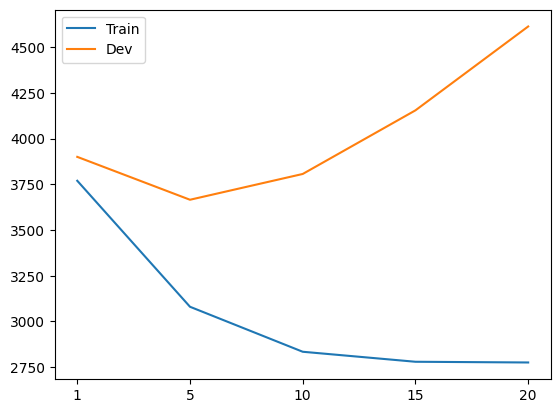

In [13]:
# Plot the perplexity of each topic model
ks = [1, 5, 10, 15, 20]
train_scores, dev_scores = test_models(M, ks)
plt.plot(np.arange(len(train_scores)), train_scores, label="Train")
plt.plot(np.arange(len(dev_scores)), dev_scores, label="Dev")
plt.xticks(np.arange(len(ks)), ['%d'%k for k in ks])
plt.legend()
plt.show()

# Part 3: Visualization

Now, for the exciting part! Let's use the topic model you just trained to inspect the data visually.

First, Let's train the model with the amount of topics that minimized perplexity above...

In [14]:
# TODO: Train the model on the full data using the number of topics you chose above (i.e., the value of k that minimized perplexity on dev).

best_k = 5 # The number of Topics that got the best perplexity
topic_model = train_topic_model(M, best_k) # Train the topic model with best_k topics
topics = preview_topics(topic_model, idx2word)

To start, we want to visualize our Term Document Matrix, but that can be difficult to visualize because each document is represented by a 5000 component vector. Thus in order to visualize our Matrix, we will want to use **dimensionality reduction** to reduce the number of components to 2 so that we can plot each Document on a 2D grid.  

In the cell below, we'll make use of PCA (Principle Component Analysis), a process that uses SVD (Singular Value Decomposition) to extract out the 2 most important Principal Components of our data which we can use to visualize our Matrix. You will NOT need to code this process from scratch, instead we'll make use of `sklearn.decomposition.PCA` to do it for you.

- The output of `PCA.fit_transform()` is a matrix of shape `(n_samples, n_components)`, where `n_samples = #documents`, and `n_components = 2`, in our case. We will treat each row `i` of the output as 2D coordinates for document `i`.
- Check out the PCA documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [15]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# NOTE: This code initialized our PCA model to project our matrix M into 2 dimensions
def pca_projection(M : np.ndarray[np.float64], n_components : int = 2) -> np.ndarray[np.float64]:
  """
  Use PCA to project M into n_components.
  Note: You do NOT need to code this function.

  Parameters
  ----------
  M : np.ndarray[float]
    The input Term Document Matrix
  n_components : int
    The number of components/dimensions that you want to reduce to

  Returns
  -------
  proj : np.ndarray[float]
    The projected matrix (M projected to n_components)
  """
  pca = PCA(n_components) # PCA model with n_components = 2
  proj = pca.fit_transform(M) # Projections: An np.array of shape (n_samples, n_components)
  return proj


With this projection we can now plot all of the documents on a 2d plane, but ideally we want each point to be colored by their "most prominent Topic" and contain some more identifying data about the document.

TODO: In order to achieve this, for each point lets create a function to build a dataframe **df** such that
1. Each row corresponds to one of the documents
2. The **topic** column maps each Document to it's "Most Prominent Topic"
3. The **text** column maps each Document to the a quick text snippet from the Document (the first 100 characters of the Document's raw text)
4. The **x** and **y** columns map to the (x, y) coordinates of the 2d projection

To help you start we have created an empty dataframe with the columns defined in but with no data. Please fill in this dataframe with information from **docs**.


In [16]:
def generate_datapoints(docs : List[spacy.tokens.Doc], proj: np.ndarray[np.float64], M : np.ndarray[np.float64], topic_model: LatentDirichletAllocation) -> pd.DataFrame:
  """
  Generates a Pandas Dataframe where each row corresponds to the data point (document). Specifically:
    1. The (x, y) coordinates of the projected document
    2. The text of the document (capped at 100 characters)
    3. The most prominent topic of the document (As a string of the topic number e.g. "2")
  An empty Dataframe with the required columns is already set up for you. Please fill it in and return it.
  To help, the related topic_scores and projections for each document are already calculated for you!

  Parameters
  ----------
  docs : List[Doc]
    A list of spacy preprocessed documents
  M : np.ndarray[float]
    The input Term Document Matrix
  proj: np.ndarray[float]
    The projection matrix which is M projected to 2d space using our previously defined pca_projection function
  topic_model: LatentDirichletAllocation
    The trained topic model

  Returns
  -------
  df : DataFrame
    The filled out Dataframe
  """

  data = []

  # HINT: To help you find the "Most Prominent Topic" for each document, we can use our topic model to transform M so that
  #       we get a matrix of shape (num_documents, num_topic), where each entry is the "Prominence" score of that topic for that document.
  topic_scores = topic_model.transform(M)

  for i, doc in enumerate(docs):

    topic_index = np.argmax(topic_scores[i])
    topic = str(topic_index)
    text = str(doc.text[:100])
    x, y = proj[i]
    doc2data = {'topic': topic, 'text': text, 'x': x, 'y': y}
    data.append(doc2data)

  df = pd.DataFrame(data=data)


  # TODO: Fill out the dataframe with all of the columns filled out for each document (row).
  #       You're free to implement this however you wish (please see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
  #       However it might be easiest to first create a list of dictionaries and then call the pd.DataFrame constructor on the list
  ...

  return df

Now, run the following cell to plot the PCA projection of our documents onto 2D! Each point corresponds to a document, which you can hover over and view some of the contents of!

In [17]:
# This plots the plot_data list built in the previous cell, nothing to do here
df = generate_datapoints(spacy_processed_docs, pca_projection(M, 2), M, topic_model)
fig = px.scatter(df, x="x", y="y", color="topic", hover_data=['text'])
fig.show()


## Geographical Visualization

Now, we'd like you to visualize the most popular topics based on geographical location!

We'll start with a simple bar graph showing the popularity of topics by state, where the height of each bar is the proportion of documents from each location that correspond to a particular topic.

To visualize the most popular counts by location and topic we first need to group and count the number of documents that have that "most prominent topic" and who originate from that location.

TODO: Please fill in the `generate_location_data` function which takes in a list of locations and documents and creates a Dictionary that maps each topic to a Dictionary of {Location : Count}

In [18]:
def generate_location_data(docs : List[spacy.tokens.Doc], M : np.ndarray[np.float64], locations : List[str], topic_model: LatentDirichletAllocation) -> Dict[int, Dict[str, int]]:
  """
  Aggregates the Documents that all share the same "Most Prominent Topic" and retains a count of the number of Documents at each location
  for each Document. This will be used to generate a Bar Chart visualization and Map Visualization of where each Topic is most popular.

  Parameters
  ----------
  docs : List[Doc]
    A list of spacy preprocessed documents
  M : np.ndarray[float]
    The input Term Document Matrix
  locations : List[str]
    A list that records the location of each document. Thus, the location of i-th document is doc_locations[i]
  topic_model: LatentDirichletAllocation
    The trained topic model

  Returns
  -------
  location_count : Dict[int, Dict[str, int]]
    A dictionary that maps each topic (int) to a Dictionary mapping Location (str) to Counts (int) for that topic.
    This is designed so that
      * location_count[topic][state] is the count of documents for that state and topic
  """
  location_count = {}

  # HINT: To help you find the "Most Prominent Topic" for each document, we can use our topic model to transform M so that
  #       we get a matrix of shape (num_documents, num_topic), where each entry is the "Prominence" score of that topic for that document.
  topic_scores = topic_model.transform(M)

  topics2locations = {}

  for i, doc in enumerate(docs):
    prominent_topic = np.argmax(topic_scores[i])
    location = locations[i]

    if prominent_topic in location_count:
      if location in location_count[prominent_topic]:
        location_count[prominent_topic][location] += 1
      else:
        location_count[prominent_topic][location] = 1
    else:
      location_count[prominent_topic] = {location: 1}



  # Hint: It may be helpful to first create a dictionary mapping Topics (int) to a List of Locations
  #       of the documents who have the Topic as it's "Most Prominent Topic"
  ...
  return location_count


With this, we can use the `generate_location_data` function to aggregate the number of locations for each topic and then generate our Bar Graphs. Nothing more needs to be done here.

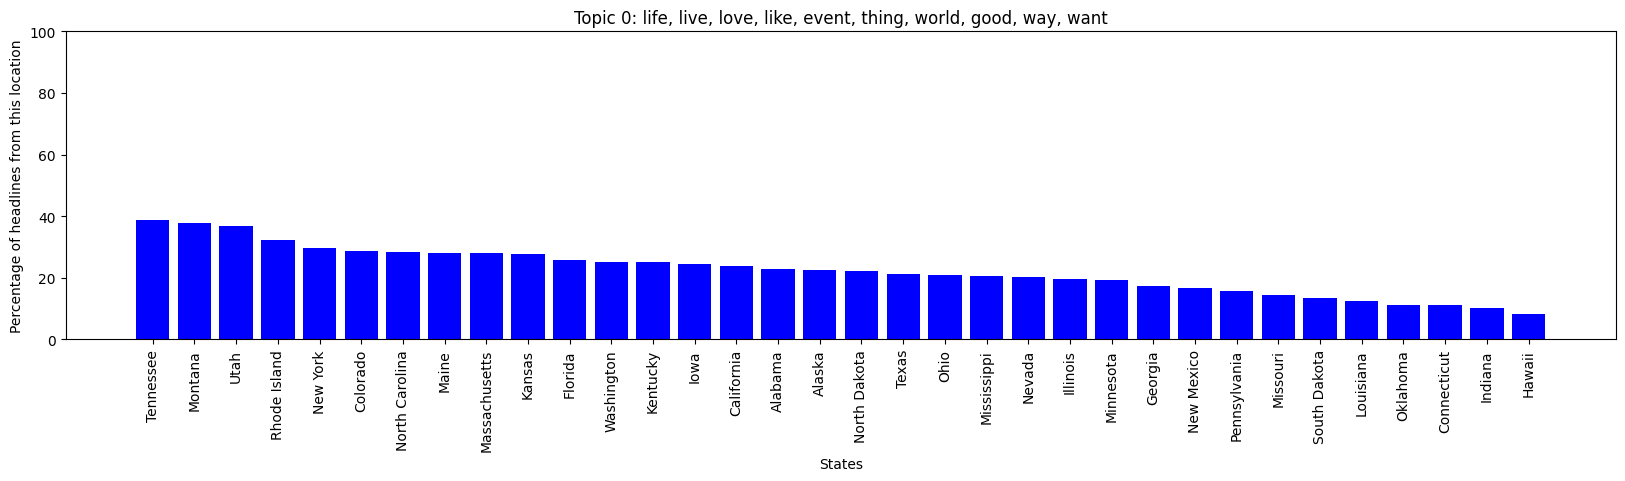

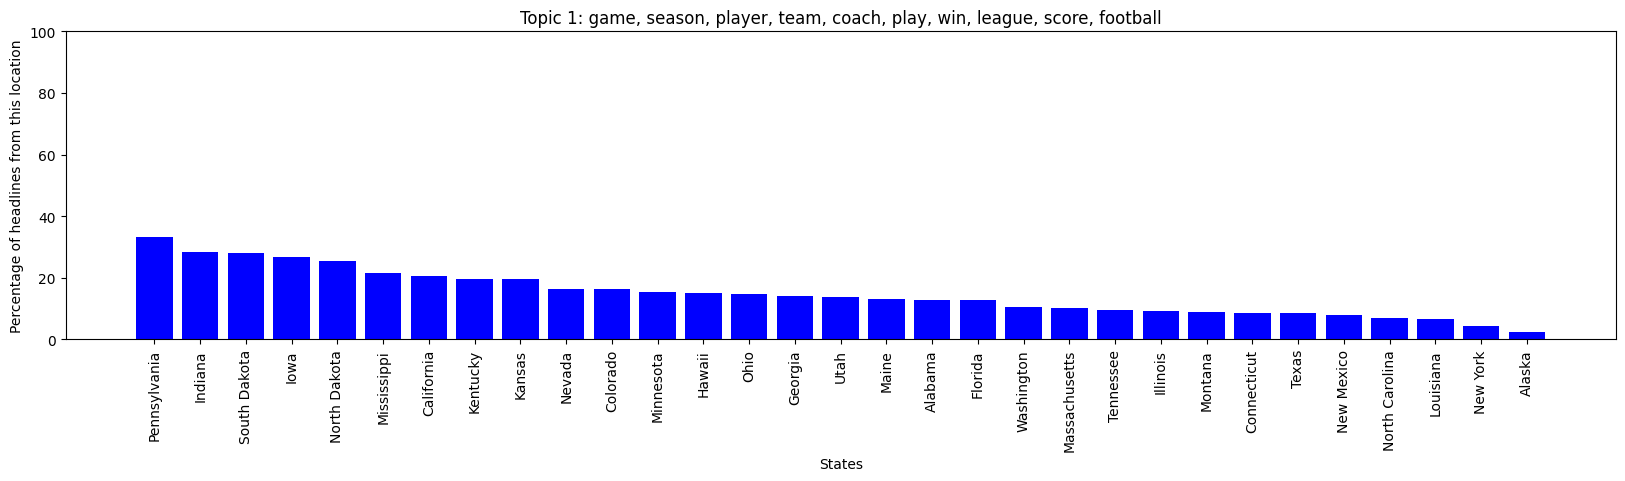

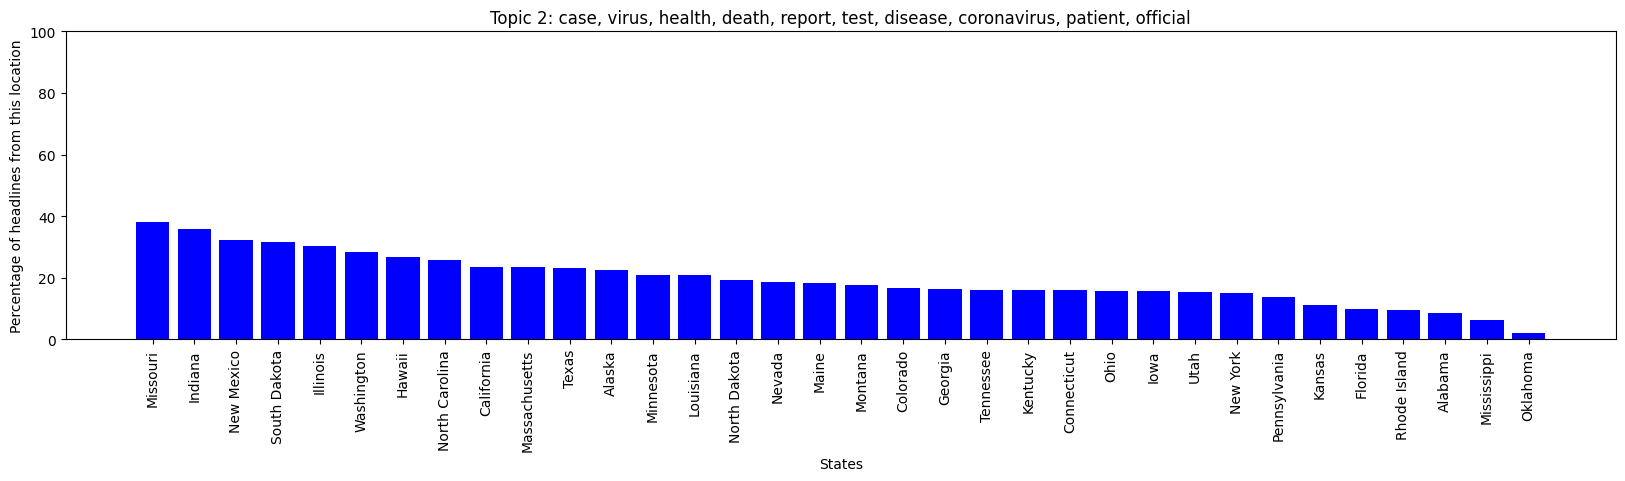

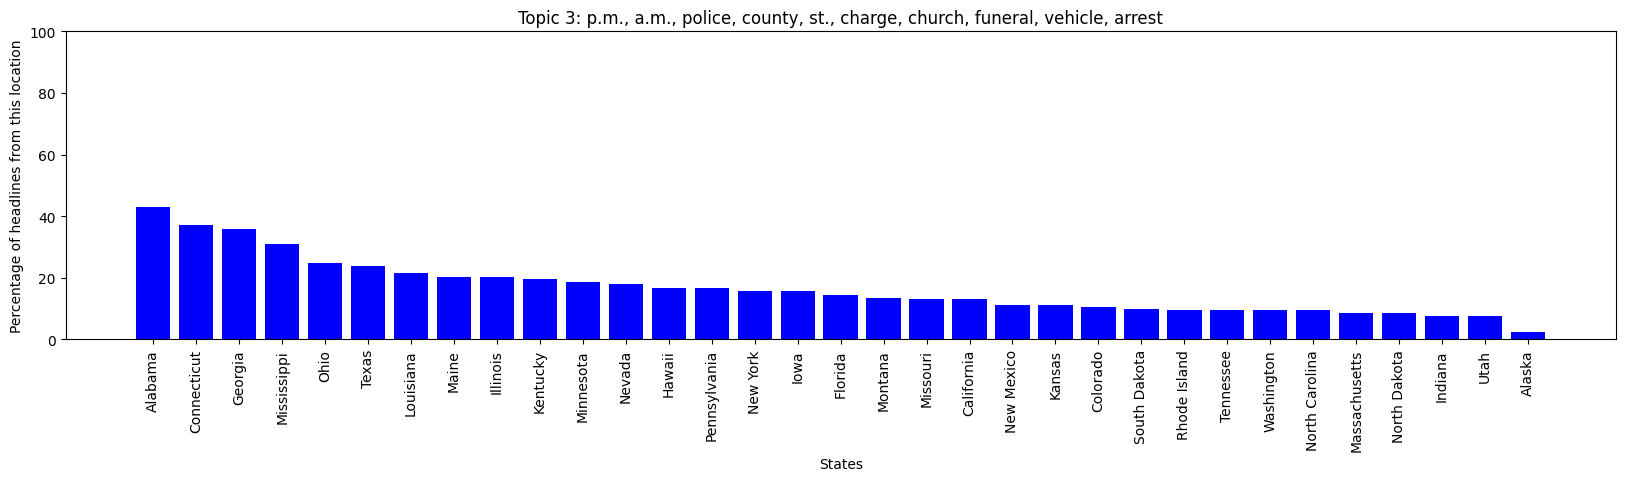

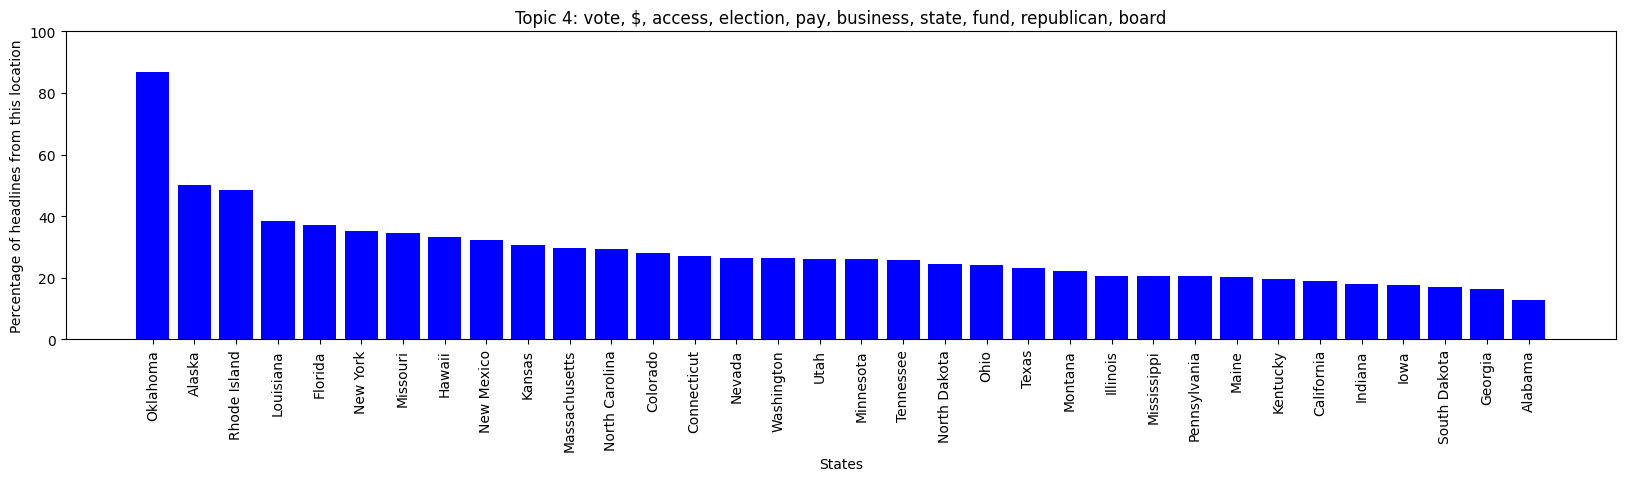

In [19]:
from collections import Counter

state_count = generate_location_data(spacy_processed_docs, M, doc_locations, topic_model)

# This code makes a bar graph displaying the popularity (as a proportion) per state...
for k in range(best_k):
  fig = plt.figure(figsize=(20,4))

  threshold = 30

  total_doc_counts = dict(Counter(doc_locations).items())
  normalized_state_count = {loc : 100 * state_count[k][loc] / total_doc_counts[loc] for loc in state_count[k] if total_doc_counts[loc] > threshold}
  state_items = sorted(normalized_state_count.items(), key = lambda item: item[1], reverse = True)
  state_names = [item[0] for item in state_items]
  count = np.array([item[1] for item in state_items])

  plt.bar(state_names, count, color ='blue', width = .8)
  plt.ylim([0, 100])
  plt.xticks(rotation=90)
  plt.xlabel("States")
  plt.ylabel("Percentage of headlines from this location")
  plt.title(f"Topic {k}: {', '.join(topics[k])}")
  plt.show()

Now, we'll use a library to plot the number of documents of each topic on a map, because it's much more visually intuitive than a bar graph!

In [20]:
# This cell is giving an error because of Geocoder availability
'''
from geopy.geocoders import Nominatim
import plotly.graph_objects as go

# Our geolocation service
geolocator = Nominatim(user_agent='myapplication')
for k in range(best_k):
  lon, lat = [], []

  threshold = 30

  total_doc_counts = dict(Counter(doc_locations).items())
  normalized_state_count = {loc : 100 * state_count[k][loc] / total_doc_counts[loc] for loc in state_count[k] if total_doc_counts[loc] > threshold}
  state_items = sorted(normalized_state_count.items(), key = lambda item: item[1], reverse = True)
  state_names = [item[0] for item in state_items]
  count = np.array([item[1] for item in state_items])

  labels = []
  # Assign each state a geographical location
  for state, c in zip(state_names, count):
    location = geolocator.geocode(state)
    lat.append(location.latitude)
    lon.append(location.longitude)
    labels.append(f"{state} : {c}% of all {state} headlines have this topic")

  marker = dict(color="blue", size=count)
  fig = go.Figure(data=go.Scattergeo(lon=lon, lat=lat, text=labels, mode='markers', marker=marker))
  fig.update_layout(title = f"Topic {k}: {', '.join(topics[k])}" ,geo_scope='usa')
  fig.show()
  '''

GeocoderUnavailable: ignored

## 4. Conceptual Questions

In this section, you may need to write more code to answer the conceptual questions—much of which will draw from code you've already written above. Do *not* change any code you've already written above; make duplicates in this section to edit, if necessary. Create markdown cells for written responses.

### Question 1: Threshold?
When we plotted the bar graphs and geographical graphs, we included a line `threshold=30` to exclude some states.
Create code cell(s) below to re-create the bar graphs with the same topic model without excluding any states. Which topics now have different top states? Using one of these topics and its new top state as an example, why was the threshold necessary?

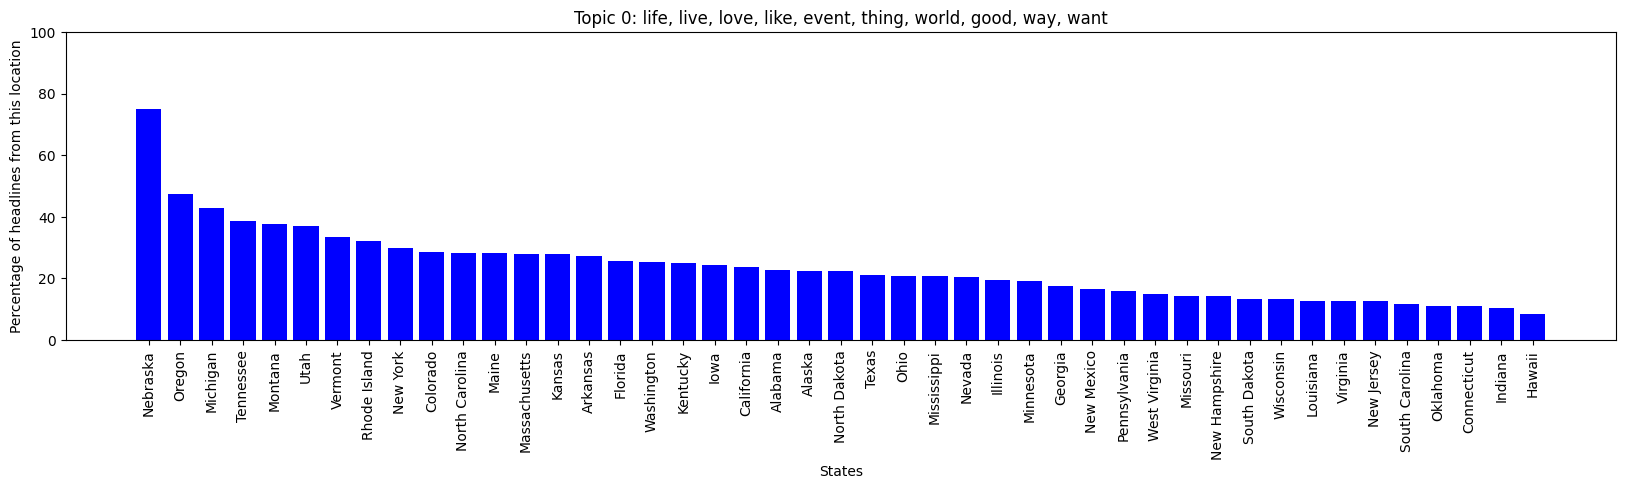

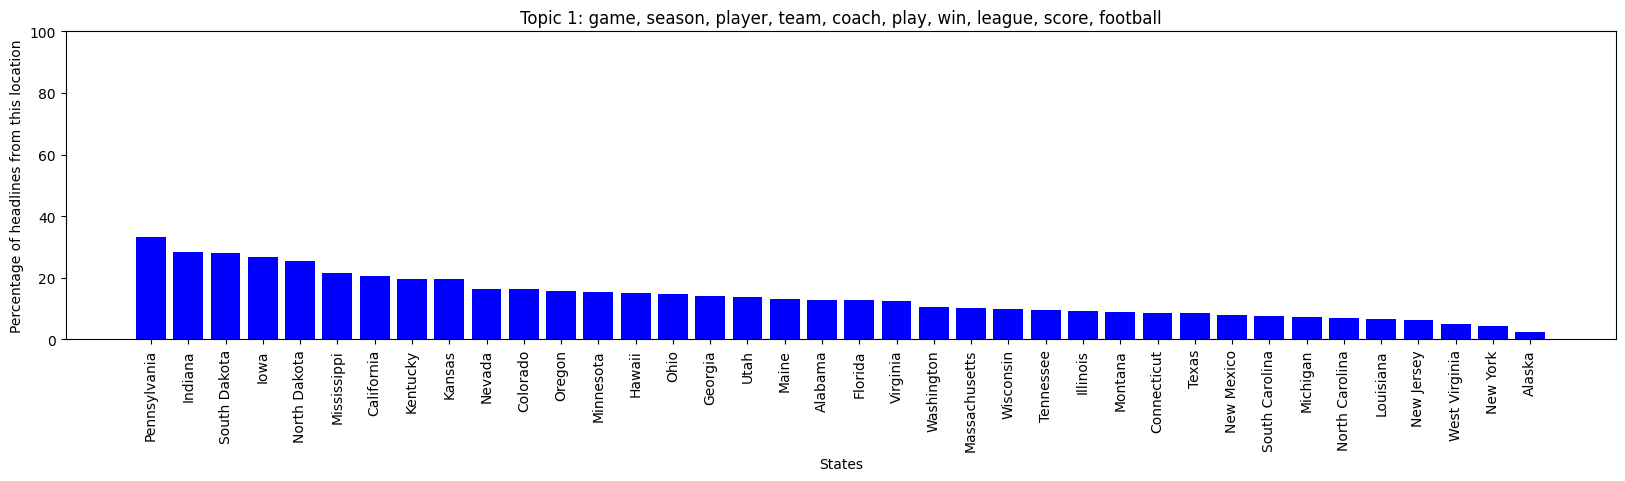

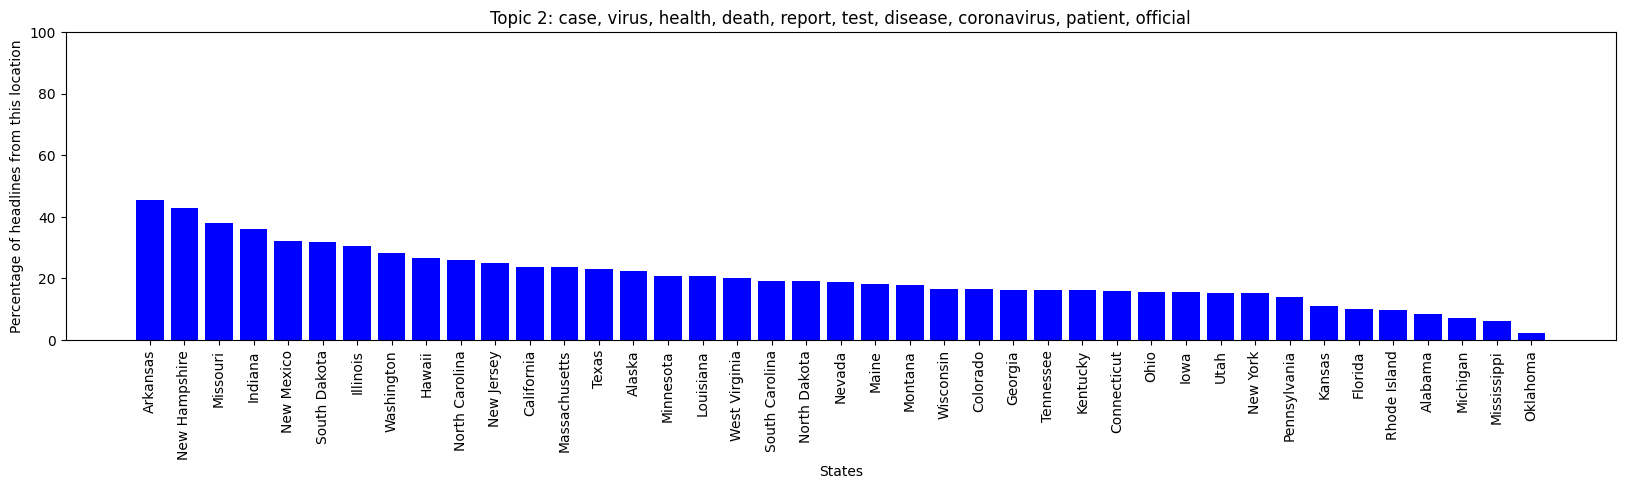

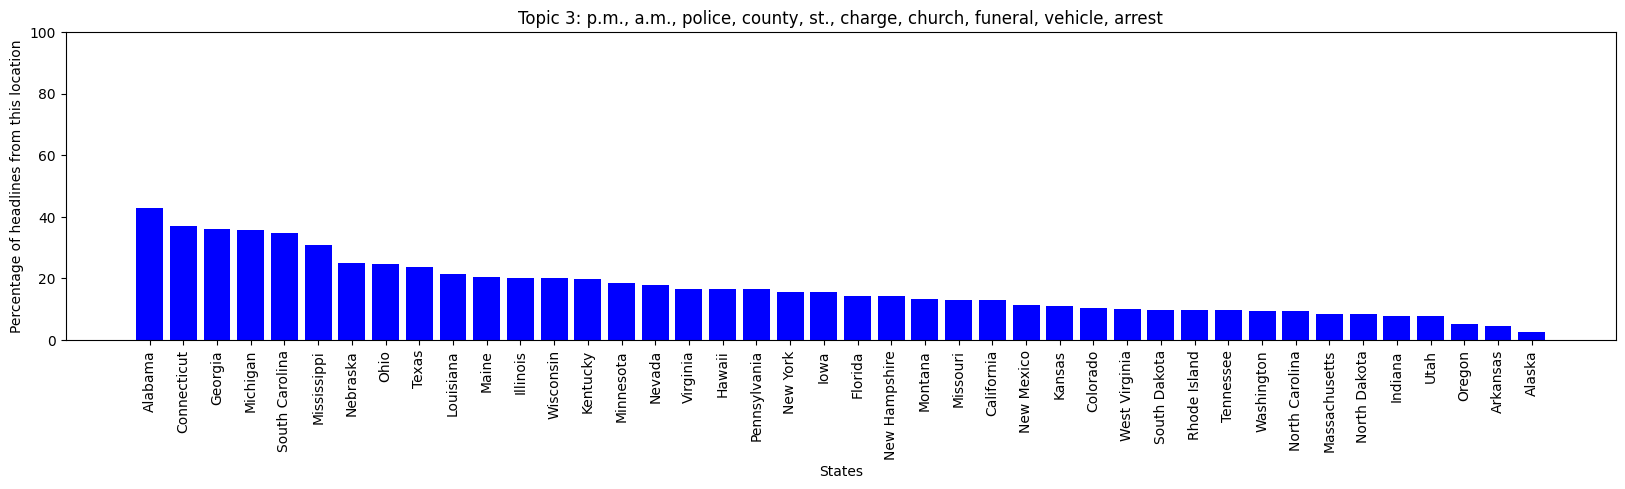

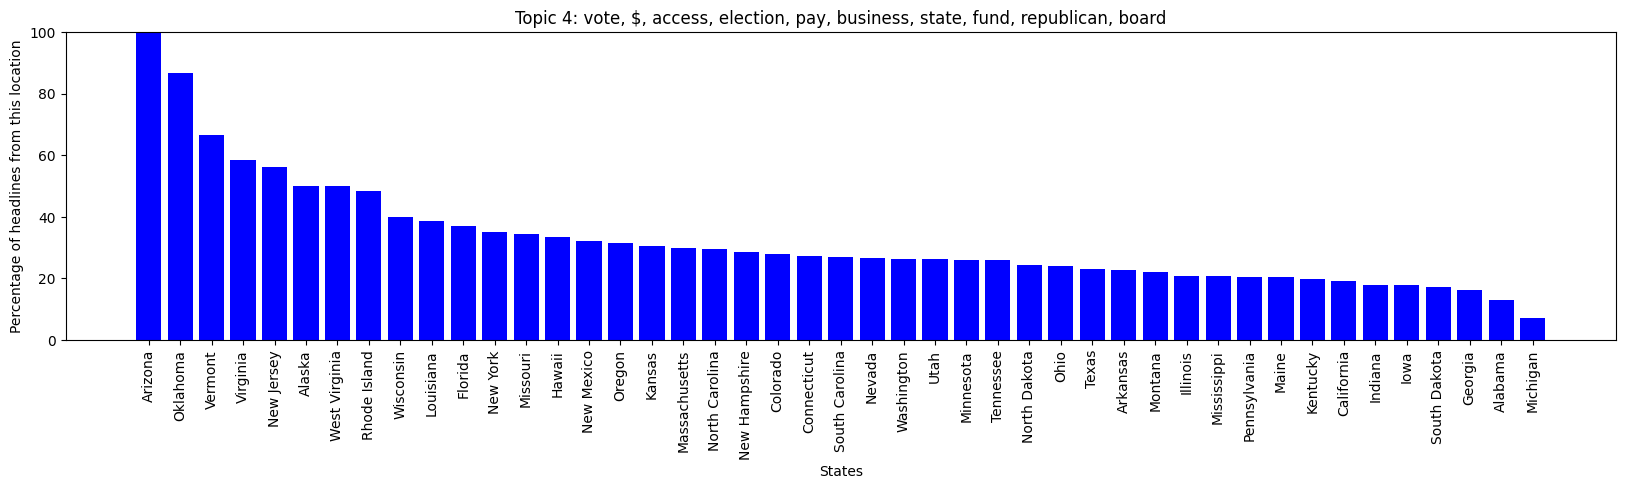

In [21]:
from collections import Counter

state_count = generate_location_data(spacy_processed_docs, M, doc_locations, topic_model)
for k in range(best_k):
  fig = plt.figure(figsize=(20,4))

  threshold = 0
  total_doc_counts = dict(Counter(doc_locations).items())
  normalized_state_count = {loc : 100 * state_count[k][loc] / total_doc_counts[loc] for loc in state_count[k] if total_doc_counts[loc] > threshold}
  state_items = sorted(normalized_state_count.items(), key = lambda item: item[1], reverse = True)
  state_names = [item[0] for item in state_items]
  count = np.array([item[1] for item in state_items])

  plt.bar(state_names, count, color ='blue', width = .8)
  plt.ylim([0, 100])
  plt.xticks(rotation=90)
  plt.xlabel("States")
  plt.ylabel("Percentage of headlines from this location")
  plt.title(f"Topic {k}: {', '.join(topics[k])}")
  plt.show()

ANSWER:
Differences:
Topic 0: With threshold - Tennessee, Without threshold - Nebraska
Topic 2: With threshold - Missouri, Without threshold - Arkansas
Topic 4: With threshold - Oklahoma, Without threshold - Arizona

The threshold is used to normalize on the basis of number of documents associated with a certain location. Therefore, when we remove the threshold, there can be certain locations that are mentioned less in the corpus (lower number of documents) and thus their normalized scores become very high. This may not actually be representative and thus the threshold is important.

For example, there are only 9 documents with the location Arizona but all are associated with topic 4. It is misleading to then definitively say that topic 4 is more popular in Arizona than in Okhlahoma, because our corpus provides insufficient data.

### Question 2: Perplexed on Perplexity
We asked you to plot a perplexity graph to choose the number of topics that minimizes perplexity on held-out data. Please answer the following questions:
- What is perplexity in the context of our topic model?
- Why does perplexity not necessarily decrease by increasing the number of topics?


ANSWER: The probability of the data in the test set are extremely small floats between 0 and 1. To make these probabilities more interpretable, we take the inverse of their natural logs. Then, we try and minimize the resulting 'perplexity'.

As seen in our results, perplexity decreases from 1 to 5. This is because, when only 1 topic is provided, the data is underfitted. At 5, the intended amount of fitting takes place; we know this because after 5, perplexity decreases for the train dataset but increases for the test dataset due to overfitting




# Submission Instructions
Please submit this Colab as **two** files to Gradescope:
1.   A `.py` file: Click File > Download > Download .py
2.   A `.ipynb` file ***WITH OUTPUTS***: Click Runtime > Run All, and then after all outputs are complete, click File > Download > Download .ipynb
3. **ONLY if you intend to mark a submission as your final submission for grading**, create a blank file titled "FINAL" to submit with the two files above.
  - We will only grade the *first* submission marked with a "FINAL" file.
  - If your submission by the grading deadline does not have a "FINAL" file, we will grade the first submission with a "FINAL" file under our late grading policy.
  - We recommend making one 'dry-run' submission to make sure it passes all the tests you expect to pass, before submitting the same files again with a "FINAL" file.

Please ensure that the `.ipynb` contains actual function outputs (and not leftover print statements, for instance). We will run your `.ipynb` file; if our outputs don't match the outputs in your submitted file (within reason), you will receive a 0 on this assignment.

Please also keep any helper functions that you create for your implementation on the same cell and keep the cells to the function definition and print statements that we provided ONLY for best Autograder results. Thank you!